<a href="https://colab.research.google.com/github/Gosiuniunia/Sieci-neuronowe/blob/main/convnext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ConvNeXt implementation using PyTorch on Cifat10 dataset.

Architecture proposed in Liu, Zhuang, et al. "A convnet for the 2020s." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2022. Avalilable at: https://arxiv.org/pdf/2201.03545

Original code: https://github.com/facebookresearch/ConvNeXt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
# Data folder path
folder_path = '/content/drive/MyDrive/convnext'

In [3]:
!pip install torchinfo

In [34]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from timm.layers import DropPath, trunc_normal_
from tqdm import tqdm
from torchinfo import summary
import pandas as pd
import seaborn as sn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [35]:
# Dataset
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [18]:
class LayerNorm(nn.Module):
    """ Performs Layer Normalization with inputs shape (batch_size, channels, height, width) or (batch_size, channels) for Global Average Pooling"""
    def __init__(self, normalized_shape, eps=1e-6, gap=False):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.normalized_shape = (normalized_shape, )
        self.gap = gap

    def forward(self, x):
        if self.gap ==True:
          # x: (N, C)
          return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        else:
          # x: (N, C, H, W)
          mean = x.mean(dim=1, keepdim=True)
          var = ((x - mean) ** 2).mean(dim=1, keepdim=True)
          x = (x - mean) / torch.sqrt(var + self.eps)

          return self.weight[:, None, None] * x + self.bias[:, None, None]

In [19]:
class Block(nn.Module):
    """ Basic ConvNeXt Block. Used implementation:
    DwConv -> LayerNorm -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W).
    Architecture was created for ImageNet with image dimension 256x256.
    This implementation was adjusted to CIFAR10."""
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()

        self.dwconv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim) # Original kernel_size=7
        self.norm = LayerNorm(dim) # Layer Normnalization instead of Batch Normalization
        self.pwconv1 = nn.Conv2d(dim, 4 * dim, kernel_size=1)
        self.act = nn.GELU() # GELU activation function instead of ReLu
        self.pwconv2 = nn.Conv2d(4 * dim, dim, kernel_size=1)

        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim)) if layer_scale_init_value > 0 else None # Layer Scale
        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity() # Stochastic Depth

    def forward(self, x):
        shortcut = x # Residual connection

        x = self.dwconv(x)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma[:, None, None] * x

        x = shortcut + self.drop_path(x)
        return x

In [20]:
class ConvNeXt(nn.Module):
    """ Main ConvNeXt architecture adapted for CIFAR10. """
    def __init__(self, in_chans=3, num_classes=10, dims=[64, 128, 256],
                 depths=[2, 4, 6], drop_path_rate=0.1,
                 layer_scale_init_value=1e-6):
        super().__init__()

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=3, stride=1, padding=1), # Original kernel_size=4, stride=4, without padding
            LayerNorm(dims[0])
        )

        # Downsampling layers - layer between every pair of stages
        self.downsampling_layers = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.downsampling_layers.append(nn.Sequential(
                LayerNorm(dims[i]),
                nn.Conv2d(dims[i], dims[i + 1], kernel_size=2, stride=2)
            ))

        # Stages - 4 in original, reduced to 3 for CIFAR10
        self.stages = nn.ModuleList()
        dp_rates = torch.linspace(0, drop_path_rate, sum(depths)).tolist()
        idx = 0

        for d, dim in zip(depths, dims):
            blocks = [Block(dim, drop_path=dp_rates[idx + j], layer_scale_init_value=layer_scale_init_value) for j in range(d)]
            self.stages.append(nn.Sequential(*blocks))
            idx += d

        # Head
        self.norm = LayerNorm(dims[-1], gap=True)
        self.head = nn.Linear(dims[-1], num_classes)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)

        for stage, down in zip(self.stages, self.downsampling_layers + [None]):
            x = stage(x)
            if down is not None:
                x = down(x)

        x = self.norm(x.mean([-2, -1])) # Global Average Pooling

        return self.head(x)

In [37]:
# Training loop

def train(model, optimizer, scheduler, criterion, epochs, train_loader, test_loader, model_name):
  train_losses, test_losses = [], []
  train_accs, test_accs = [], []
  best_acc = 0.90

  for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      correct, total = 0, 0
      for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", ncols=100):
          images, labels = images.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

      epoch_loss = running_loss / total
      epoch_acc = correct / total
      train_losses.append(epoch_loss)
      train_accs.append(epoch_acc)

      model.eval()
      running_loss = 0.0
      correct, total = 0, 0
      with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)

              running_loss += loss.item() * images.size(0)
              _, predicted = outputs.max(1)
              total += labels.size(0)
              correct += predicted.eq(labels).sum().item()

      test_loss = running_loss / total
      test_acc = correct / total
      test_losses.append(test_loss)
      test_accs.append(test_acc)

      if (test_acc > best_acc) or (epoch == (epochs-1)):
        best_acc = test_acc
        torch.save(model.state_dict(), f"{folder_path}/{model_name}_epoch_{epoch+1}.pth")

      scheduler.step()

      print(f"Epoch {epoch+1}/{epochs}: Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.4f}, Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
  return train_losses, test_losses, train_accs, test_accs

In [22]:
# Parameters
epochs = 30
lr = 4e-3

In [ ]:
# First configuration
model = ConvNeXt()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

train_losses, test_losses, train_accs, test_accs = train(model, optimizer, scheduler, criterion, epochs, train_loader, test_loader, 'convnext_1')

In [38]:
# Second configuration with weight deacy and label soothing
model = ConvNeXt()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

train_losses, test_losses, train_accs, test_accs = train(model, optimizer, scheduler, criterion, epochs, train_loader, test_loader, 'convnext_2')

Epoch 1: 100%|████████████████████████████████████████████████████| 391/391 [02:04<00:00,  3.13it/s]


Epoch 1/30: Train Loss=1.9738, Train Acc=0.2887, Test Loss=1.7970, Test Acc=0.3578


Epoch 2: 100%|████████████████████████████████████████████████████| 391/391 [02:09<00:00,  3.02it/s]


Epoch 2/30: Train Loss=1.6893, Train Acc=0.4429, Test Loss=1.5215, Test Acc=0.5273


Epoch 3: 100%|████████████████████████████████████████████████████| 391/391 [02:10<00:00,  3.00it/s]


Epoch 3/30: Train Loss=1.4931, Train Acc=0.5445, Test Loss=1.3215, Test Acc=0.6311


Epoch 4: 100%|████████████████████████████████████████████████████| 391/391 [02:06<00:00,  3.10it/s]


Epoch 4/30: Train Loss=1.3548, Train Acc=0.6145, Test Loss=1.2162, Test Acc=0.6834


Epoch 5: 100%|████████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 5/30: Train Loss=1.2705, Train Acc=0.6541, Test Loss=1.1569, Test Acc=0.7115


Epoch 6: 100%|████████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 6/30: Train Loss=1.1973, Train Acc=0.6900, Test Loss=1.0822, Test Acc=0.7414


Epoch 7: 100%|████████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 7/30: Train Loss=1.1320, Train Acc=0.7192, Test Loss=1.0137, Test Acc=0.7755


Epoch 8: 100%|████████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 8/30: Train Loss=1.0658, Train Acc=0.7520, Test Loss=0.9655, Test Acc=0.7957


Epoch 9: 100%|████████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 9/30: Train Loss=1.0049, Train Acc=0.7782, Test Loss=0.9147, Test Acc=0.8184


Epoch 10: 100%|███████████████████████████████████████████████████| 391/391 [02:06<00:00,  3.10it/s]


Epoch 10/30: Train Loss=0.9644, Train Acc=0.7983, Test Loss=0.9196, Test Acc=0.8149


Epoch 11: 100%|███████████████████████████████████████████████████| 391/391 [02:06<00:00,  3.10it/s]


Epoch 11/30: Train Loss=0.9289, Train Acc=0.8137, Test Loss=0.8770, Test Acc=0.8325


Epoch 12: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 12/30: Train Loss=0.8960, Train Acc=0.8267, Test Loss=0.8532, Test Acc=0.8459


Epoch 13: 100%|███████████████████████████████████████████████████| 391/391 [02:04<00:00,  3.13it/s]


Epoch 13/30: Train Loss=0.8699, Train Acc=0.8415, Test Loss=0.8208, Test Acc=0.8604


Epoch 14: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 14/30: Train Loss=0.8409, Train Acc=0.8522, Test Loss=0.8151, Test Acc=0.8621


Epoch 15: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 15/30: Train Loss=0.8166, Train Acc=0.8627, Test Loss=0.7904, Test Acc=0.8724


Epoch 16: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 16/30: Train Loss=0.7936, Train Acc=0.8747, Test Loss=0.7594, Test Acc=0.8874


Epoch 17: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.13it/s]


Epoch 17/30: Train Loss=0.7713, Train Acc=0.8838, Test Loss=0.7538, Test Acc=0.8896


Epoch 18: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 18/30: Train Loss=0.7452, Train Acc=0.8950, Test Loss=0.7625, Test Acc=0.8868


Epoch 19: 100%|███████████████████████████████████████████████████| 391/391 [02:04<00:00,  3.13it/s]


Epoch 19/30: Train Loss=0.7269, Train Acc=0.9031, Test Loss=0.7431, Test Acc=0.8935


Epoch 20: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 20/30: Train Loss=0.7068, Train Acc=0.9118, Test Loss=0.7240, Test Acc=0.9016


Epoch 21: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.12it/s]


Epoch 21/30: Train Loss=0.6873, Train Acc=0.9206, Test Loss=0.7149, Test Acc=0.9075


Epoch 22: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.11it/s]


Epoch 22/30: Train Loss=0.6727, Train Acc=0.9259, Test Loss=0.7062, Test Acc=0.9105


Epoch 23: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.11it/s]


Epoch 23/30: Train Loss=0.6535, Train Acc=0.9364, Test Loss=0.7060, Test Acc=0.9090


Epoch 24: 100%|███████████████████████████████████████████████████| 391/391 [02:04<00:00,  3.13it/s]


Epoch 24/30: Train Loss=0.6369, Train Acc=0.9440, Test Loss=0.6969, Test Acc=0.9140


Epoch 25: 100%|███████████████████████████████████████████████████| 391/391 [02:04<00:00,  3.13it/s]


Epoch 25/30: Train Loss=0.6231, Train Acc=0.9511, Test Loss=0.6904, Test Acc=0.9181


Epoch 26: 100%|███████████████████████████████████████████████████| 391/391 [02:04<00:00,  3.14it/s]


Epoch 26/30: Train Loss=0.6127, Train Acc=0.9545, Test Loss=0.6921, Test Acc=0.9173


Epoch 27: 100%|███████████████████████████████████████████████████| 391/391 [02:04<00:00,  3.14it/s]


Epoch 27/30: Train Loss=0.6073, Train Acc=0.9566, Test Loss=0.6877, Test Acc=0.9207


Epoch 28: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.13it/s]


Epoch 28/30: Train Loss=0.6000, Train Acc=0.9603, Test Loss=0.6901, Test Acc=0.9191


Epoch 29: 100%|███████████████████████████████████████████████████| 391/391 [02:05<00:00,  3.13it/s]


Epoch 29/30: Train Loss=0.5948, Train Acc=0.9637, Test Loss=0.6875, Test Acc=0.9207


Epoch 30: 100%|███████████████████████████████████████████████████| 391/391 [02:04<00:00,  3.13it/s]


Epoch 30/30: Train Loss=0.5947, Train Acc=0.9627, Test Loss=0.6870, Test Acc=0.9209


In [56]:
# Model loading
model_name = "convnext_2"
epoch_result = 30
model_file_path = f"{folder_path}/{model_name}_epoch_{epoch_result}.pth"

loaded_model = ConvNeXt().to(device)
loaded_model.load_state_dict(torch.load(model_file_path))
summary(loaded_model)

Layer (type:depth-idx)                   Param #
ConvNeXt                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─LayerNorm: 2-2                    128
├─ModuleList: 1-2                        --
│    └─Sequential: 2-3                   --
│    │    └─LayerNorm: 3-1               128
│    │    └─Conv2d: 3-2                  32,896
│    └─Sequential: 2-4                   --
│    │    └─LayerNorm: 3-3               256
│    │    └─Conv2d: 3-4                  131,328
├─ModuleList: 1-3                        --
│    └─Sequential: 2-5                   --
│    │    └─Block: 3-5                   33,920
│    │    └─Block: 3-6                   33,920
│    └─Sequential: 2-6                   --
│    │    └─Block: 3-7                   133,376
│    │    └─Block: 3-8                   133,376
│    │    └─Block: 3-9                   133,376
│    │    └─Block: 3-10                  133,376
│    └─Sequential: 2-7      

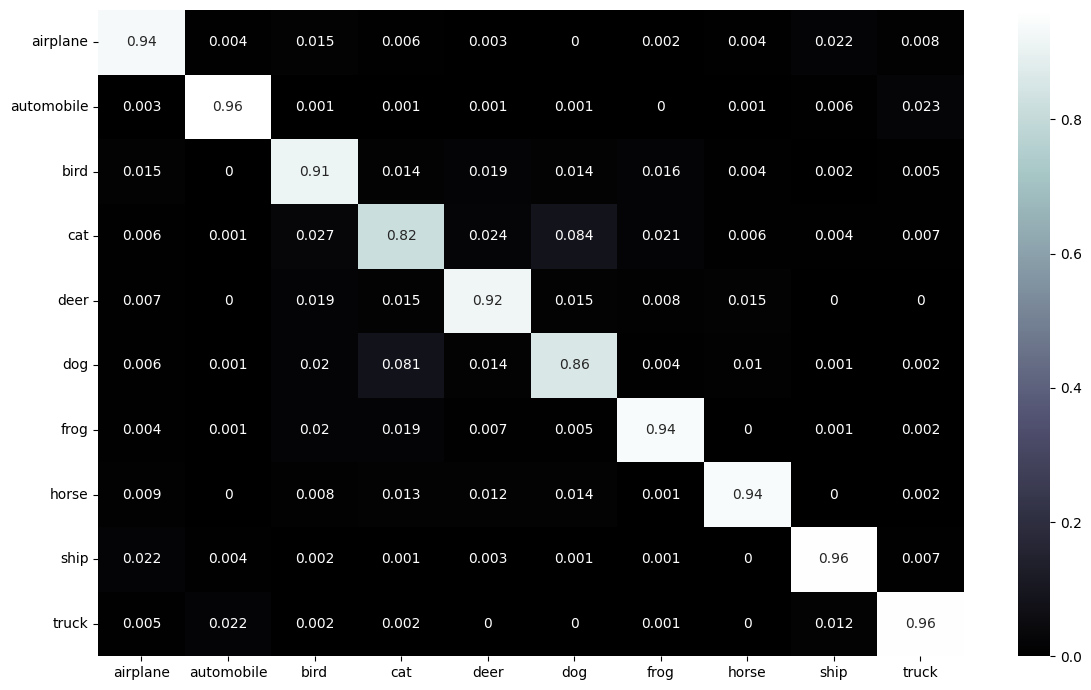

In [60]:
# Model prediction and evaluation
predicted_labels = []
actual_labels = []
class_names = test_set.classes

loaded_model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = loaded_model(inputs)
        _, predicted = outputs.max(1)
        actual_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(12,7))
sn.heatmap(conf_matrix/np.sum(conf_matrix)*10, annot=True, cmap='bone', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.show()

In [61]:
report = classification_report(actual_labels, predicted_labels, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

    airplane     0.9240    0.9360    0.9300      1000
  automobile     0.9669    0.9630    0.9649      1000
        bird     0.8888    0.9110    0.8998      1000
         cat     0.8436    0.8200    0.8316      1000
        deer     0.9173    0.9210    0.9192      1000
         dog     0.8653    0.8610    0.8632      1000
        frog     0.9457    0.9410    0.9434      1000
       horse     0.9592    0.9410    0.9500      1000
        ship     0.9523    0.9590    0.9557      1000
       truck     0.9447    0.9560    0.9503      1000

    accuracy                         0.9209     10000
   macro avg     0.9208    0.9209    0.9208     10000
weighted avg     0.9208    0.9209    0.9208     10000



In [54]:
import json
# Training history saving
filename = f"trainmetrics_{model_name}.json"

with open(f"{folder_path}/{filename}", "w") as f:
    json.dump({
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accs": train_accs,
        "test_accs": test_accs
    }, f, indent=4)

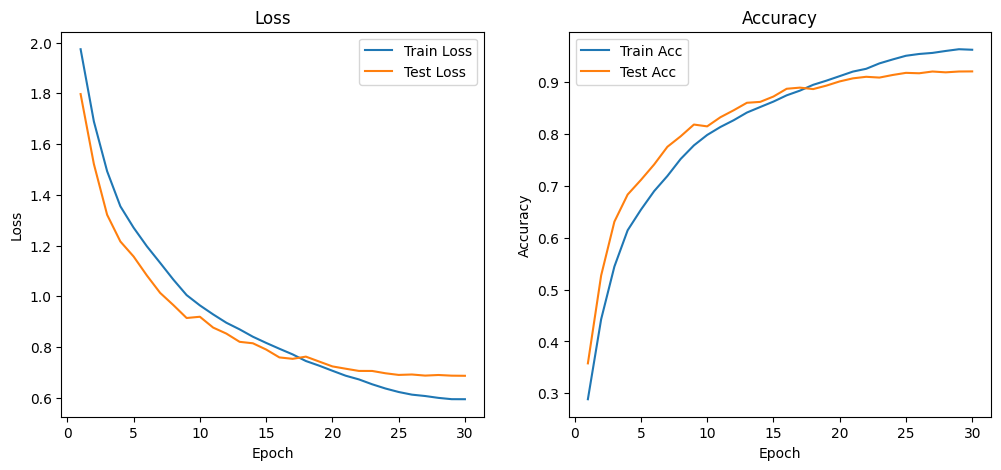

In [62]:
history_filename = "trainmetrics_convnext_2.json"

with open(f"{folder_path}/{filename}", "r") as f:
    data = json.load(f)

    train_losses = data["train_losses"]
    test_losses = data["test_losses"]
    train_accs = data["train_accs"]
    test_accs = data["test_accs"]

    epochs = len(train_losses)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss')

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accs, label='Train Acc')
plt.plot(range(1, epochs+1), test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy')

plt.show()